In [1]:
# Importing Packages
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import numpy             as np
import math
import cv2

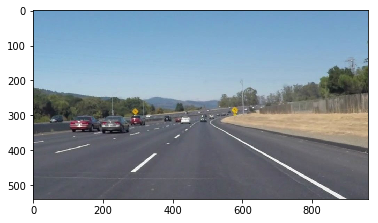

In [3]:
# Load an image
image = mpimg.imread("C:\\Users\\GuwalgiyaGuan\\examples_images\\solidWhiteCurve.jpg")
plt.imshow(image)

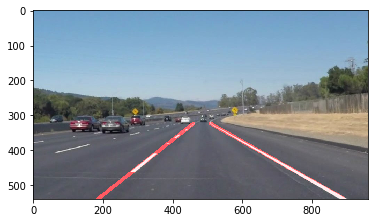

In [9]:
marked_image = mark_image(image)
plt.imshow(marked_image)

In [4]:
kernel_size    = 3
low_threshold  = 50
high_threshold = 150

# Region-of-interest vertices
trap_bottom_width = 0.85
trap_top_width    = 0.7
trap_height       = 0.4

# Hough Transform
rho             = 2
theta           = 1 * np.pi / 180
threshold        = 15
min_line_length = 10
max_line_gap    = 20

In [5]:
def mark_image(image):
    out_image = filter(image)
    out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2GRAY)
    out_image = cv2.GaussianBlur(out_image, (kernel_size, kernel_size), 0)
    edges     = cv2.Canny(out_image, low_threshold, high_threshold)
    imshape   = image.shape
    vertices  = np.array([[\
        ((imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0])]]\
        , dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    line_image   = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    initial_image    = image.astype("uint8")
    annotated_image = cv2.addWeighted(line_image, 0.8, initial_image, 1, 0.) 
    return annotated_image

In [6]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # In case of error, don't draw the line
    draw_right = True
    draw_left = True
    
    # Find slopes of all lines
    # But only care about lines where abs(slope) > slope_threshold
    slope_threshold = 0.5
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]
        
        # Calculate slope
        if x2 - x1 == 0.:  # corner case, avoiding division by 0
            slope = 999.  # practically infinite slope
        else:
            slope = (y2 - y1) / (x2 - x1)
            
        # Filter lines based on slope
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
        
    lines = new_lines
    
    # Split lines into right_lines and left_lines, representing the right and left lane lines
    # Right/left lane lines must have positive/negative slope, and be on the right/left half of the image
    right_lines = []
    left_lines = []
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] / 2  # x coordinate of center of image
        if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
            right_lines.append(line)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            left_lines.append(line)
            
    # Run linear regression to find best fit line for right and left lane lines
    # Right lane lines
    right_lines_x = []
    right_lines_y = []
    
    for line in right_lines:
        x1, y1, x2, y2 = line[0]
        
        right_lines_x.append(x1)
        right_lines_x.append(x2)
        
        right_lines_y.append(y1)
        right_lines_y.append(y2)
        
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = m*x + b
    else:
        right_m, right_b = 1, 1
        draw_right = False
        
    # Left lane lines
    left_lines_x = []
    left_lines_y = []
    
    for line in left_lines:
        x1, y1, x2, y2 = line[0]
        
        left_lines_x.append(x1)
        left_lines_x.append(x2)
        
        left_lines_y.append(y1)
        left_lines_y.append(y2)
        
    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  # y = m*x + b
    else:
        left_m, left_b = 1, 1
        draw_left = False
    
    # Find 2 end points for right and left lines, used for drawing the line
    # y = m*x + b --> x = (y - b)/m
    y1 = img.shape[0]
    y2 = img.shape[0] * (1 - trap_height)
    
    right_x1 = (y1 - right_b) / right_m
    right_x2 = (y2 - right_b) / right_m
    
    left_x1 = (y1 - left_b) / left_m
    left_x2 = (y2 - left_b) / left_m
    
    # Convert calculated end points from float to int
    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
    
    # Draw the right and left lines on image
    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros(img.shape, dtype=np.uint8)  # this produces single-channel (grayscale) image
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)  # 3-channel RGB image
    draw_lines(line_img, lines)
    #draw_lines_debug2(line_img, lines)
    return line_img


In [7]:
def region_of_interest(image, vertices):
    mask = np.zeros_like(image)
    
    if len(image.shape) > 2:
        num_channel       = img.shape[2]
        ignore_mask_color = (255, ) * channel_count
    else:
        ignore_mask_color = 255
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    return cv2.bitwise_and(image, mask)

In [8]:
def filter(image):
    white_threshold = 200
    lower_white     = np.array([white_threshold] * 3)
    upper_white     = np.array([255]             * 3)
    white_mask      = cv2.inRange(image, lower_white, upper_white)
    white_image     = cv2.bitwise_and(image, image, mask = white_mask)
    
    hsv          = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,  100, 100])
    upper_yellow = np.array([110, 255, 255])
    yellow_mask  = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask = yellow_mask)
    
    image_out    = cv2.addWeighted(white_image, 1., yellow_image, 1., 0)
    
    return image_out